In [13]:
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from collections import defaultdict

In [2]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

22/10/10 22:07:44 WARN Utils: Your hostname, Runyus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.12 instead (on interface en0)
22/10/10 22:07:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 22:07:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/10 22:07:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Consumer Distribution

In [5]:
consumer_sdf = read_file(spark, 'new_consumer_data.parquet/', '../data/curated/')

|> Loading File...


|> Loading Finished!
-RECORD 0---------------------------------
 consumer_id | 680810                     
 name        | Courtney Mendez            
 address     | 802 Knapp Harbors Apt. 769 
 state       | QLD                        
 postcode    | 9013                       
 gender      | Female                     
 user_id     | 71144                      
only showing top 1 row



In [6]:
consumer_df=consumer_sdf.groupby('state').count()
consumer_df = consumer_df.toPandas()
result = consumer_df.values.tolist()

In [7]:
x_vals =[]
y_vals = []
for i in range(len(result)):
    x_vals.append(result[i][0])
    y_vals.append(result[i][1])
    for j in range(len(result[i])):
        if result[i][0]  == 'WA':
            result[i][0] = 'Western Australia'
        elif result[i][0]  == 'NT':
            result[i][0] = 'Northern Territory'
        elif result[i][0]  == 'ACT':
            result[i][0] = 'Australian Capital Territory'
        elif result[i][0]  == 'SA':
            result[i][0] = 'South Australia'
        elif result[i][0]  == 'TAS':
            result[i][0] = 'Tasmania'
        elif result[i][0]  == 'QLD':
            result[i][0] = 'Queensland'
        elif result[i][0]  == 'VIC':
            result[i][0] = 'Victoria'
        elif result[i][0]  == 'NSW':
            result[i][0] = 'New South Wales'

In [8]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.faker import Faker

c = (
    Pie()
    .add(
        "",
        result,
        radius=["40%", "75%"],
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Pie-Radius"),
        legend_opts=opts.LegendOpts(orient="vertical", pos_top="15%", pos_left="2%"),
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
#     .render("pie_radius.html")
)
c.render_notebook()

# Merchant Distribution

In [9]:
merchants_df = pd.read_parquet('../data/curated/merchants_data.parquet')

In [10]:
merchants_tag = merchants_df.drop_duplicates('tags').reset_index(drop=True)

In [11]:
# Shortened label drawing
merchants_df_simplised = merchants_df.copy()
# merchants_df_simplised.tags = merchants_df.tags.apply(lambda x: re.sub(r'[^(a-z)]', '', x.split(' ')[0]) )
merchants_df_simplised.tags = merchants_df.tags.apply(lambda x: x.split(',')[0] )
merchants_df_simplised.merchant_name = merchants_df.merchant_name.apply(lambda x: x.split(' ')[0])

In [14]:
dict_data = defaultdict()
groupby_tag = merchants_df_simplised.groupby('tags')
for head, f in groupby_tag:
    child = list(f.groupby('type').size().reset_index().rename({'type': 'name', 0:'value'}, axis=1).T.to_dict().values())
    dict_data[head] = { 'name':head, 'children': child }

- Sunburst

In [17]:
from pyecharts.charts import Sunburst
from pyecharts import options as opts

"""
Gallery using pyecharts 1.2.1
Reference: https://www.echartsjs.com/examples/editor.html?c=sunburst-simple

Features not currently available:

1. Not available at the moment
"""
data = list(dict_data.values())
c = (
    Sunburst(init_opts=opts.InitOpts(width="1000px", height="900px"))
    .add(
        "",
        data_pair=data,
        highlight_policy="ancestor",
        radius=[0, "95%"],
        sort_="null",
        levels=[
            {},
            {
                "r0": "10%",
                "r": "60%",
                "itemStyle": {"borderWidth": 2},
                "label": {
                    # "rotate": 'tangential',
                }
            },
            {"r0": "60%", "r": "70%", "label": {
                "align": "right"
                }
            },
            {
                "r0": "70%",
                "r": "72%",
                "label": {"position": "outside", "padding": 3, "silent": False},
                "itemStyle": {"borderWidth": 3},
            },
        ],
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="Merchants Tags --- Sunburst"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
)
c.render_notebook()

- Scatter

In [18]:
merchants_df = merchants_df.sort_values('type', axis=0)
data = [list(merchants_df.columns)] + merchants_df.to_numpy().tolist() 

In [38]:
from pyecharts import options as opts
from pyecharts.charts import Grid, Scatter
from pyecharts.globals import ThemeType

l1_1 = (
    Scatter()
    .add_dataset(
        dimensions=[
            "merchant_name",
            "tags",
            "merchant_abn",
            "take_rate",
            {"name": "type", "type": "ordinal"},
        ],
        source=data
    )
    .add_yaxis(
        series_name="",
        y_axis=[],
        symbol_size=2.5,
        xaxis_index=1,
        yaxis_index=1,
        encode={"x": "type", "y": "take_rate", "tooltip": [0, 1, 2, 3]}, 
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
            type_="category",
            grid_index=0,
            name="Type",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(interval=0),
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value", 
            name="Rate",
        ),
        title_opts=opts.TitleOpts(title="Encode and Matrix"),
    )
    
)




l1_2 = (
    Scatter()
    .add_dataset()
    .add_yaxis(
        series_name="",
        y_axis=[],
        symbol_size=2.5,
        xaxis_index=1,
        yaxis_index=1,
        encode={"x": "take_rate", "y": "tags", "tooltip": [0, 1, 2, 3]}, 
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            type_="category",
            grid_index=1,
            name="Type",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(rotate=10, interval=0),
        ),
        xaxis_opts=opts.AxisOpts(
            type_="value", 
            name="Rate",
        ),
    )
)


grid = (
    # theme: WESTEROS, ROMA
    Grid(init_opts=opts.InitOpts(width="1960px", height="960px", theme=ThemeType.WESTEROS))
    .add(
        chart=l1_1,
        grid_opts=opts.GridOpts(pos_left="80%"),
        grid_index=0,
    )
    .add(
        chart=l1_2,
        grid_opts=opts.GridOpts(pos_left="28%", pos_right="25%"),
        grid_index=1,
    )
)
grid.render_notebook()

- tag summary

In [20]:
dict_data = defaultdict()
groupby_tags = merchants_df.groupby('type')
for h, d in groupby_tags:
    dict_data[h] = d.groupby('tags')['merchant_abn'].count()

In [23]:
from pyecharts import options as opts
from pyecharts.charts import Bar, Grid, Line, Pie

keys = list(dict_data.keys())

bar = (
    Bar()
    .add_xaxis(list(dict_data[keys[0]].index))
    .add_yaxis(keys[4], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[3], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[2], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[1], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[0], dict_data[keys[0]].to_list(), stack="stack1")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="Bar-Stacked Diagram by Types of Merchants", pos_top="2%", pos_left="30%"),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(rotate=-45),
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
    
)


pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(keys, merchants_df.groupby('type')['merchant_abn'].count().to_list())],
        radius=["20%", "55%"],
        center=["80%", "40%"],
        rosetype="area",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Pie-Total Types of Merchant Score Count", pos_top="8%", pos_left="65%"),
        legend_opts=opts.LegendOpts(pos_left="70%", pos_top="75%"),
    )
)

grid2 = (
    Grid(init_opts=opts.InitOpts(width="1960px", height="960px", theme=ThemeType.WESTEROS))
    .add(bar, grid_opts=opts.GridOpts(pos_right="40%", pos_bottom="40%"))
    .add(pie, grid_opts=opts.GridOpts(pos_left="90%"))
   )
grid2.render_notebook()

- Violin

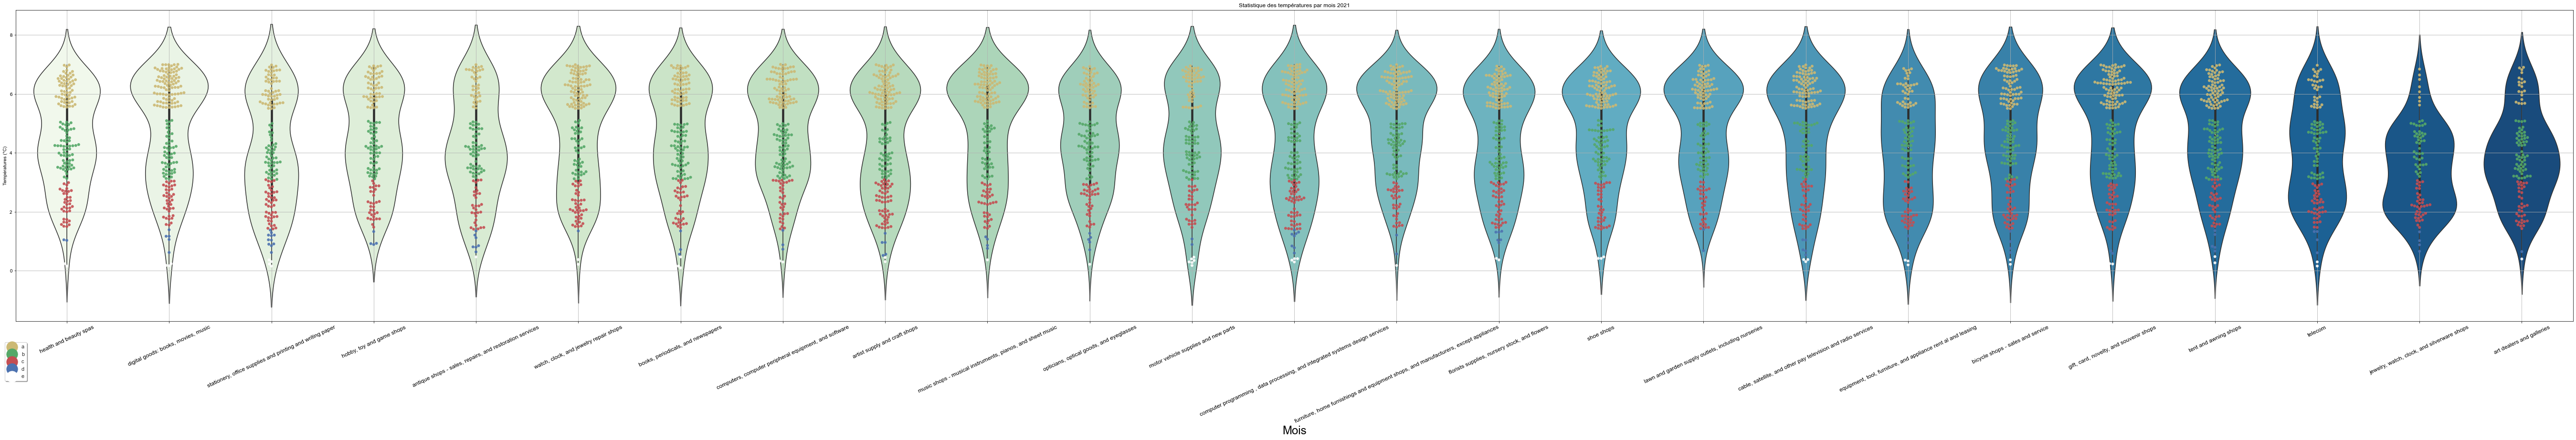

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(96,12))
fontsize=18

# Set the colour of the figure form
plt.rcParams['figure.facecolor'] = 'black'

# Set the colour of the axes drawing area
plt.rcParams['axes.facecolor'] = 'black'

plt.rcParams['font.size']=24


plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

plt.xticks( rotation=25, fontsize=12)
sns.set(color_codes=True)

sns.set_style("white")
sns.violinplot(x = merchants_df['tags'],
               y = merchants_df['take_rate'],
               ax=ax,
               palette="GnBu",
               inner = "box",
               )
# sns.stripplot(x = merchants_df['tags'],
#                y = merchants_df['take_rate'], color ='w', size = 4, alpha = 0.9, jitter=True)

sns.swarmplot(x = merchants_df['tags'],
               y = merchants_df['take_rate'], 
               hue = merchants_df['type'],
               palette = ['y','g','r','b','w'],
               size = 6, alpha = 0.9)

ax.set_title('Statistique des températures par mois 2021')
ax.set_xlabel('Mois', fontsize=24)
ax.set_ylabel('Températures (°C)')
ax.grid(True)
ax.legend(loc='lower center',bbox_to_anchor=(0, -0.2),markerscale=3,shadow=True)


plt.show()  

# Geographic Location

Problem: postcodes need to correspond to the POA in the external SA2 dataset in the user table. \
Solution: select the population data for 2020 & 2021 from the SA2 dataset, mapping the geographic locations to postcodes in the user table by occupancy, and another external location data to support. Fill last few null values by average separately.

# Fill_merchant

Problem: Some merchant information in the transaction table that does not appear in the merchant table.\
Solution: constract models to predict merchant tags and take rates.\
At first, read data and apply one hot encoder and hard code to change attributes into numerical types.
Then use a classification model and linear regression model to predict merchant tags and take rates.

# Statistical Model

Use the following three models to predict fraud probability。\
Comparing RMSE, it is found that both the user and merchant are more suitable for Decision Tree Regressor model.\
We decided to use this model to support ranking.

Consumer Model Evaluation

| Model Name               | Root Mean Squared Error (RMSE) |
|--------------------------|--------------------------------|
| Decision Tree Regressor  | 2.91557                        |
| Linear Regression        | 4.18831                        |
| Generalized Linear Model | 4.24882                        |

Merchant Model Evaluation

| Model Name               | Root Mean Squared Error (RMSE) |
|--------------------------|--------------------------------|
| Decision Tree Regressor  | 4.94800                        |
| Linear Regression        | 11.34179                       |
| Generalized Linear Model | 13.17148                       |

# Rank Model

In [28]:
rank = pd.read_parquet('../data/curated/rank_final.parquet/').sort_values('fraud_prob')

In [29]:
rank.head(5)

,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
0,52266154043,13.827869,Lobortis Tellus Justo Foundation,art dealers and galleries,6.880000,a,0,1
1,17175760321,13.835225,Morbi Metus Vivamus Industries,"hobby, toy and game shops",6.330000,a,0,2
2,15073921424,13.863471,None,telecom,4.466589,b,0,3
3,28717590335,13.877677,None,telecom,4.400445,b,0,4
1464,95856918319,13.903626,Scelerisque Scelerisque Dui Incorporated,"music shops - musical instruments, pianos, and...",6.430000,a,1,1


In [31]:
rank = rank.reset_index(drop=True).reset_index().rename({'index': 'total_rank'}, axis=1)
rank['total_rank'] = rank['total_rank']+1

In [32]:
rank_data = [list(rank.columns)] + rank.to_numpy().tolist() 

In [33]:
rank.head(5)

,total_rank,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
0,1,52266154043,13.827869,Lobortis Tellus Justo Foundation,art dealers and galleries,6.880000,a,0,1
1,2,17175760321,13.835225,Morbi Metus Vivamus Industries,"hobby, toy and game shops",6.330000,a,0,2
2,3,15073921424,13.863471,None,telecom,4.466589,b,0,3
3,4,28717590335,13.877677,None,telecom,4.400445,b,0,4
4,5,95856918319,13.903626,Scelerisque Scelerisque Dui Incorporated,"music shops - musical instruments, pianos, and...",6.430000,a,1,1


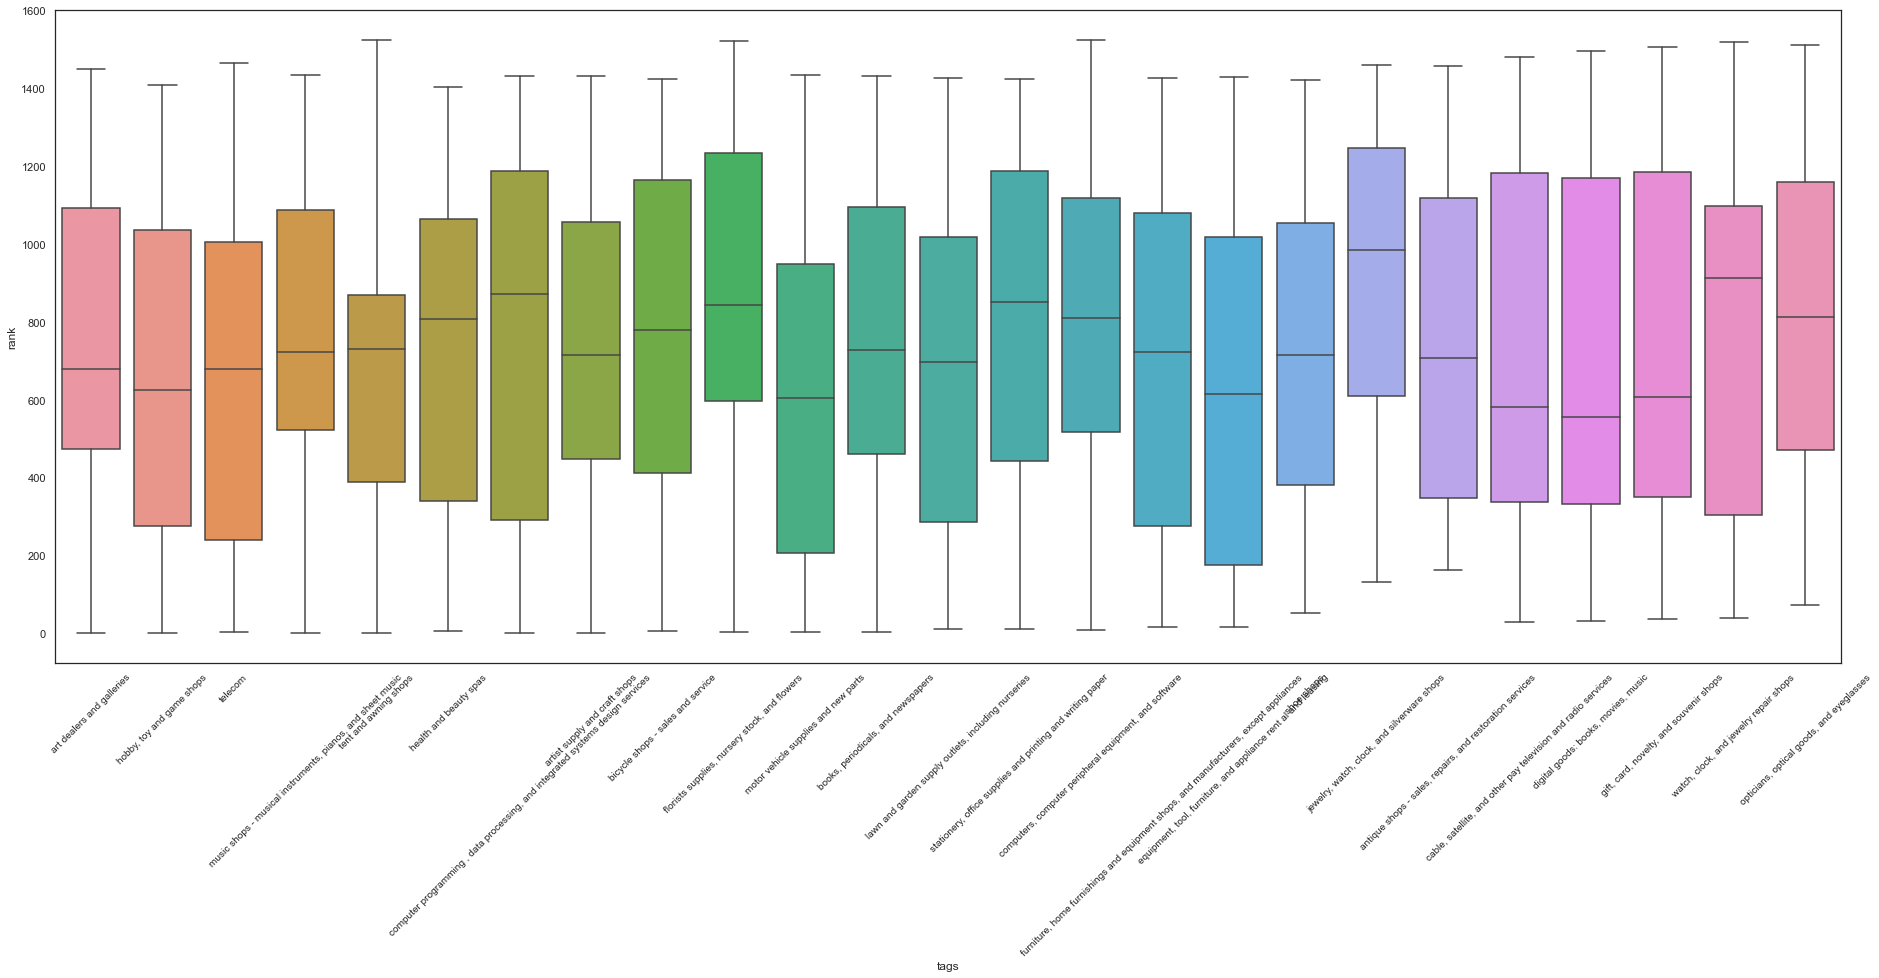

In [46]:
plt.figure(figsize=(32,12))
y1=rank["rank"]
daytripdur=sns.boxplot(x="tags", y=y1, data=rank)
plt.xticks( rotation=45, fontsize=10)
plt.show()

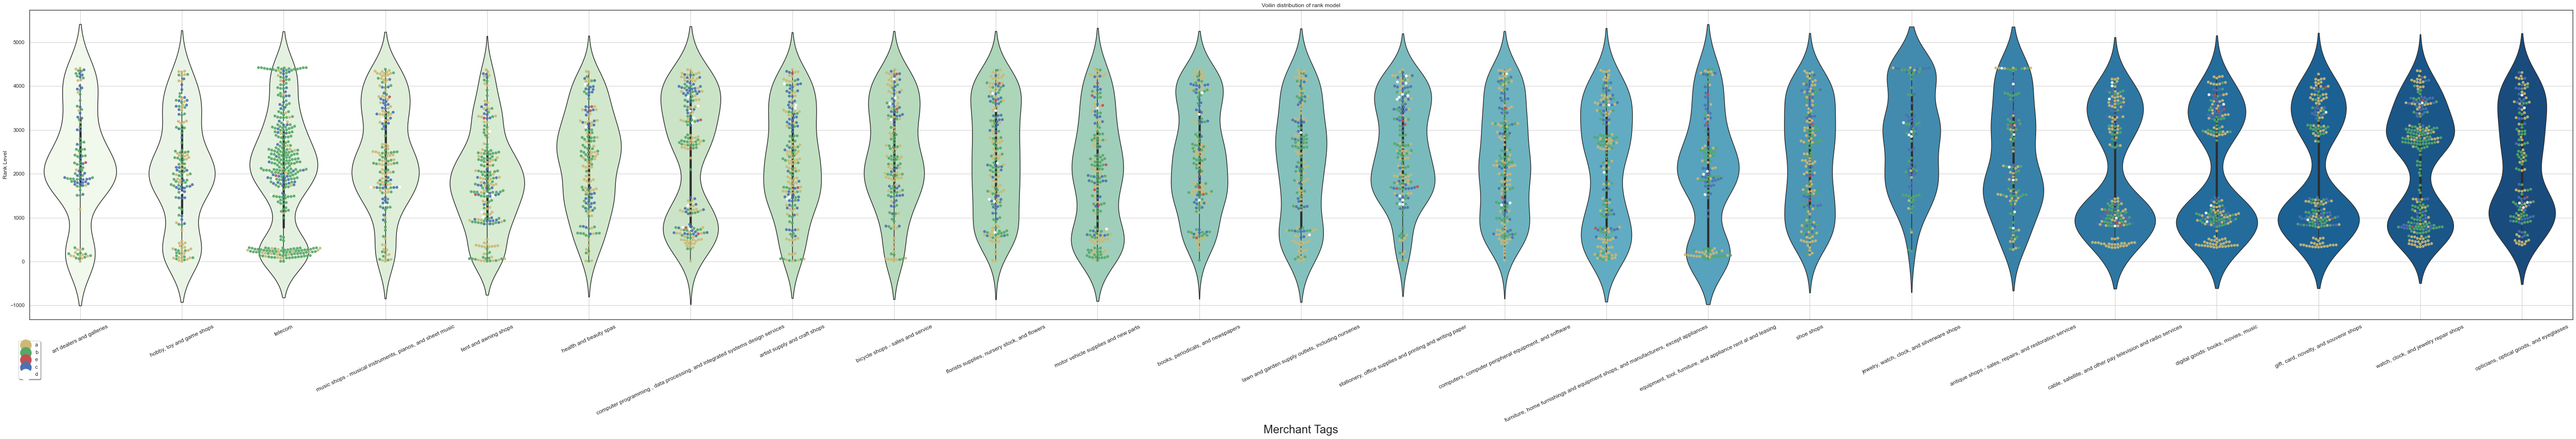

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(96,12))
fontsize=18

# Set the colour of the figure form
plt.rcParams['figure.facecolor'] = 'black'

# Set the colour of the axes drawing area
plt.rcParams['axes.facecolor'] = 'black'

plt.rcParams['font.size']=24


plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

plt.xticks( rotation=25, fontsize=12)
sns.set(color_codes=True)

sns.set_style("white")
sns.violinplot(x = rank['tags'],
               y = rank['total_rank'],
               ax=ax,
               palette="GnBu",
               inner = "box",
               )


sns.swarmplot(x = rank['tags'],
               y = rank['total_rank'], 
               hue = rank['type'],
               palette = ['y','g','r','b','w'],
               size = 6, alpha = 0.9)

ax.set_title('Voilin distribution of rank model')
ax.set_xlabel('Merchant Tags', fontsize=24)
ax.set_ylabel('Rank Level')
ax.grid(True)
ax.legend(loc='lower center',bbox_to_anchor=(0, -0.2),markerscale=3,shadow=True)


plt.show()  

### Top 100

In [5]:
rank.head(100)

,total_rank,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
0,1,52266154043,13.827869,Lobortis Tellus Justo Foundation,art dealers and galleries,6.880000,a,0,1
1,2,17175760321,13.835225,Morbi Metus Vivamus Industries,"hobby, toy and game shops",6.330000,a,0,2
2,3,15073921424,13.863471,None,telecom,4.466589,b,0,3
3,4,28717590335,13.877677,None,telecom,4.400445,b,0,4
4,5,95856918319,13.903626,Scelerisque Scelerisque Dui Incorporated,"music shops - musical instruments, pianos, and...",6.430000,a,1,1
...,...,...,...,...,...,...,...,...,...
95,96,76094539803,14.260212,Rutrum Justo Corporation,art dealers and galleries,5.090000,b,0,43
96,97,56503889644,14.264037,None,motor vehicle supplies and new parts,4.243697,b,1,35
97,98,17610103622,14.268149,Per Conubia Corporation,"lawn and garden supply outlets, including nurs...",5.510000,a,1,36
98,99,89023030428,14.276320,Ac Eleifend Inc.,"equipment, tool, furniture, and appliance rent...",5.590000,a,0,44


### Top 10 for 3 segments

`high_interval` including: 
- antique shops - sales, repairs, and restoration services, 
- art dealers and galleries, 
- bicycle shops - sales and service, 
- equipment, tool, furniture, and appliance rent al and leasing, 
- health and beauty spas, 
- hobby, toy and game shops, 
- jewelry, watch, clock, and silverware shops, 
- stationery, office supplies and printing and writing paper, 
- telecom

In [6]:
rank[rank['lifecycle_count'] == 0].sort_values('rank').head(10)

,total_rank,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
0,1,52266154043,13.827869,Lobortis Tellus Justo Foundation,art dealers and galleries,6.880000,a,0,1
1,2,17175760321,13.835225,Morbi Metus Vivamus Industries,"hobby, toy and game shops",6.330000,a,0,2
2,3,15073921424,13.863471,None,telecom,4.466589,b,0,3
3,4,28717590335,13.877677,None,telecom,4.400445,b,0,4
6,7,20877828351,13.911307,Semper Dui LLP,health and beauty spas,4.980000,b,0,5
7,8,85684792409,13.911307,Risus Donec Nibh LLC,health and beauty spas,6.370000,a,0,5
10,11,27207000299,13.911307,Egestas Sed Pharetra Limited,bicycle shops - sales and service,5.840000,a,0,5
13,14,78526643558,13.911307,Arcu Institute,health and beauty spas,6.290000,a,0,8
20,21,39961396807,13.911307,Sed Dolor Fusce LLP,"hobby, toy and game shops",5.530000,a,0,8
27,28,25876985396,13.911307,Vitae Erat Vivamus Corp.,"stationery, office supplies and printing and w...",4.190000,b,0,10


`mid_interval` including:
- artist supply and craft shops, 
- books, periodicals, and newspapers, 
- computer programming , data processing, and integrated systems design services, 
- furniture, home furnishings and equipment shops, and manufacturers, except appliances, 
- lawn and garden supply outlets, including nurseries, 
- motor vehicle supplies and new parts, 
- music shops - musical instruments, pianos, and sheet music, 
- shoe shops

In [7]:
rank[rank['lifecycle_count'] == 1].sort_values('rank').head(10)

,total_rank,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
4,5,95856918319,13.903626,Scelerisque Scelerisque Dui Incorporated,"music shops - musical instruments, pianos, and...",6.430000,a,1,1
8,9,24314208971,13.911307,Metus Ltd,"computer programming , data processing, and in...",5.730000,a,1,2
9,10,87824427219,13.911307,Phasellus Fermentum Consulting,artist supply and craft shops,6.720000,a,1,2
19,20,20073297612,13.911307,Dictum Sapien Associates,artist supply and craft shops,4.000000,b,1,4
21,22,40751557554,13.911307,Nisi Cum Industries,artist supply and craft shops,4.480000,b,1,4
22,23,35194643826,13.911307,Orci Industries,"music shops - musical instruments, pianos, and...",6.610000,a,1,4
23,24,27950649624,13.911307,None,motor vehicle supplies and new parts,4.277697,b,1,4
24,25,29917527785,13.911307,Ullamcorper Corp.,"books, periodicals, and newspapers",4.100000,b,1,4
25,26,68275485458,13.911307,Morbi Sit Inc.,artist supply and craft shops,5.620000,a,1,4
26,27,20415536115,13.911307,Nibh Phasellus Nulla Industries,"lawn and garden supply outlets, including nurs...",5.840000,a,1,10


`low_interval` including: 
- cable, satellite, and other pay television and radio services, 
- computers, computer peripheral equipment, and software, 
- digital goods: books, movies, music, 
- florists supplies, nursery stock, and flowers, 
- gift, card, novelty, and souvenir shops, 
- opticians, optical goods, and eyeglasses, 
- tent and awning shops, 
- watch, clock, and jewelry repair shops

In [8]:
rank[rank['lifecycle_count'] == 2].sort_values('rank').head(10)

,total_rank,merchant_abn,fraud_prob,merchant_name,tags,take_rate,type,lifecycle_count,rank
5,6,43308864284,13.910175,Eleifend Incorporated,tent and awning shops,4.670000,b,2,1
11,12,61569154734,13.911307,Blandit At Nisi PC,tent and awning shops,5.780000,a,2,2
12,13,57798993346,13.911307,Malesuada LLC,tent and awning shops,4.340000,b,2,2
14,15,45783462228,13.911307,Pretium Neque Morbi Company,tent and awning shops,6.610000,a,2,4
15,16,66650274915,13.911307,Gravida Praesent Industries,"florists supplies, nursery stock, and flowers",6.300000,a,2,4
16,17,29681526553,13.911307,Cras Vehicula Aliquet Corp.,tent and awning shops,6.240000,a,2,4
17,18,97748234104,13.911307,Vitae Diam PC,"florists supplies, nursery stock, and flowers",6.630000,a,2,4
18,19,60218700582,13.911307,None,tent and awning shops,4.415572,b,2,4
28,29,52379134298,13.911307,Eu Foundation,"computers, computer peripheral equipment, and ...",6.530000,a,2,9
32,33,68656010159,13.921710,Suspendisse Limited,tent and awning shops,5.970000,a,2,10
